# Śledzenie za pomocą Syjamskich sieci neuronowych: 
# Fully Convolutional Siamese Tracker
(oryginalny opis algorytmu: [klik](https://arxiv.org/pdf/1606.09549.pdf))

## Krótkie przypomnienie
*   Mierzymy podobieństwo między szukanym obiektem (wskazanym np. w pierwszej ramce), a ROI (Region of Interest - obszar, w którym spodziewamy się znaleźć obiekt w kolejnej ramce)
*   Oba wejścia przetwarzane są przez odpowiednie gałęzie sieci Syjamskiej, wyznaczone mapy cech (feature maps) są następnie porównywane, np. z użyciem korelacji
*   Powstaje heat mapa, której maksimum wskazuje lokalizację obiektu

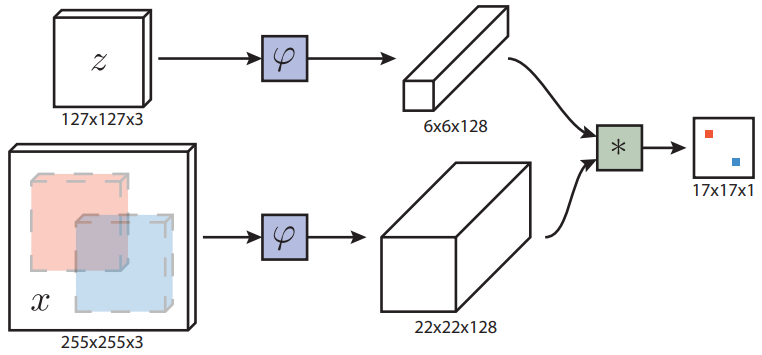

## Ćwiczenie
Ponieważ uczenie Syjamskiej sieci neuronowej do zadania śledzenia jest procesem raczej długotrwałym, w dostępnych plikach znajdziesz nauczoną sieć, a Twoim zadaniem będzie przede wszystkim "poskładanie algorytmu w całość".

Najpierw zaimportujmy potrzebne biblioteki...

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from collections import namedtuple
import time

import cv2

import os
import glob
import numpy as np

🔔 **TODO**: ustaw zmienną ``EXERCISE_PATH`` tak aby wskazywała na folder z ćwiczeniem

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
EXERCISE_PATH = "/content/drive/MyDrive/Colab Notebooks/ZAW - SiamTrack"

## Definicja sieci: backbone & head

W oryginalnym artykule autorzy zaproponowali oparcie architektury o znaną sieć AlexNet (a dokładniej jej 5 warstw konwolucyjnych). W niniejszym ćwiczeniu użyjemy innej architektury, którą opracowaliśmy w zespole w ramach prac nad implementacją śledzenia z użyciem Syjamskiej sieci neuronowej w FPGA.

Klasa ``Backbone`` reprezentuje pojedynczą gałąź Syjamskiej sieci neuronowej. Ponieważ jest w pełni konwolucyjna, może przetworzyć obraz o właściwie dowolnych rozmiarach przestrzennych. 
Klasa ``SiamFC`` realizuje połączenie dwóch gałęzi z użyciem korelacji wzajemnej.

In [ ]:
class _BatchNorm2d(nn.BatchNorm2d):

    def __init__(self, num_features, *args, **kwargs):
        super(_BatchNorm2d, self).__init__(
            num_features, *args, eps=1e-6, momentum=0.05, **kwargs)


class _AlexNet(nn.Module):
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        return x


class Backbone(_AlexNet):
    output_stride = 8

    def __init__(self):
        super(Backbone, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, 3),
            _BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 64, 3),
            _BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2))
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, 1),
            _BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2))
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 128, 3, 1),
            _BatchNorm2d(128),
            nn.ReLU(inplace=True))
        self.conv4 = nn.Sequential(
            nn.Conv2d(128, 128, 3, 1),
            _BatchNorm2d(128),
            nn.ReLU(inplace=True))
        self.conv5 = nn.Sequential(
            nn.Conv2d(128, 128, 3, 1))


class SiamFC(nn.Module):

    def __init__(self, out_scale=0.001):
        super(SiamFC, self).__init__()
        self.out_scale = out_scale
    
    def forward(self, z, x):
        return self._fast_xcorr(z, x) * self.out_scale
    
    def _fast_xcorr(self, z, x):
        # fast cross correlation
        nz = z.size(0)
        nx, c, h, w = x.size()
        x = x.view(-1, nz * c, h, w)
        out = F.conv2d(x, z, groups=nz)
        out = out.view(nx, -1, out.size(-2), out.size(-1))
        return out

## Funkcje pomocnicze

*   ``read_image`` - odczyt obrazka z pliku
*   ``show_image`` - zapis obrazka z naniesionym prostokątem otaczającym do pliku
*   ``crop_and_resize`` - wycięcie i przeskalowanie ROI z wybranej ramki



In [ ]:
def read_image(img_file, cvt_code=cv2.COLOR_BGR2RGB):
    img = cv2.imread(img_file, cv2.IMREAD_COLOR)
    if cvt_code is not None:
        img = cv2.cvtColor(img, cvt_code)
    return img


def write_image(img, boxes=None, box_fmt='ltwh', colors=None,
               thickness=3, fig_n=1, cvt_code=cv2.COLOR_RGB2BGR):
    if cvt_code is not None:
        img = cv2.cvtColor(img, cvt_code)
    
    # resize img if necessary
    max_size = 960
    if max(img.shape[:2]) > max_size:
        scale = max_size / max(img.shape[:2])
        out_size = (
            int(img.shape[1] * scale),
            int(img.shape[0] * scale))
        img = cv2.resize(img, out_size)
        if boxes is not None:
            boxes = np.array(boxes, dtype=np.float32) * scale
    
    if boxes is not None:
        assert box_fmt in ['ltwh', 'ltrb']
        boxes = np.array(boxes, dtype=np.int32)
        if boxes.ndim == 1:
            boxes = np.expand_dims(boxes, axis=0)
        if box_fmt == 'ltrb':
            boxes[:, 2:] -= boxes[:, :2]
        
        # clip bounding boxes
        bound = np.array(img.shape[1::-1])[None, :]
        boxes[:, :2] = np.clip(boxes[:, :2], 0, bound)
        boxes[:, 2:] = np.clip(boxes[:, 2:], 0, bound - boxes[:, :2])
        
        if colors is None:
            colors = [
                (0, 0, 255),
                (0, 255, 0),
                (255, 0, 0),
                (0, 255, 255),
                (255, 0, 255),
                (255, 255, 0),
                (0, 0, 128),
                (0, 128, 0),
                (128, 0, 0),
                (0, 128, 128),
                (128, 0, 128),
                (128, 128, 0)]
        colors = np.array(colors, dtype=np.int32)
        if colors.ndim == 1:
            colors = np.expand_dims(colors, axis=0)
        
        for i, box in enumerate(boxes):
            color = colors[i % len(colors)]
            pt1 = (box[0], box[1])
            pt2 = (box[0] + box[2], box[1] + box[3])
            img = cv2.rectangle(img, pt1, pt2, color.tolist(), thickness)
    
    cv2.imwrite(os.path.join(EXERCISE_PATH, "data/OTB/Dog/out", str(fig_n) + '.jpg'), img)


def crop_and_resize(img, center, size, out_size,
                    border_type=cv2.BORDER_CONSTANT,
                    border_value=(0, 0, 0),
                    interp=cv2.INTER_LINEAR):
    # convert box to corners (0-indexed)
    size = round(size)
    corners = np.concatenate((
        np.round(center - (size - 1) / 2),
        np.round(center - (size - 1) / 2) + size))
    corners = np.round(corners).astype(int)

    # pad image if necessary
    pads = np.concatenate((
        -corners[:2], corners[2:] - img.shape[:2]))
    npad = max(0, int(pads.max()))
    if npad > 0:
        img = cv2.copyMakeBorder(
            img, npad, npad, npad, npad,
            border_type, value=border_value)

    # crop image patch
    corners = (corners + npad).astype(int)
    patch = img[corners[0]:corners[2], corners[1]:corners[3]]

    # resize to out_size
    patch = cv2.resize(patch, (out_size, out_size),
                       interpolation=interp)

    return patch


## Definicja Trackera

Klasa `TrackerSiamFC` definiuje algorytm śledzenia. Metoda inicjalizująca obiekt (`__init__`) zajmuje się konfiguracją, włącznie z parametrami takimi jak liczba przetwarzanych skal, rozmiary obiektu lub ROI i innymi. Metoda inicjalizująca tracker przygotowuje reprezentację obiektu, jak również filtr dla otrzymywanej _heat map_ oraz skale. Metoda `update` lokalizuje obiekt w kolejnej ramce:

*   Przygotowuje ROI dla każdej z przetwarzanych skal na podstawie poprzedniej lokalizacji obiektu.
*   Oblicza odpowiedzi (_heat maps_) Syjamskiej sieci neuronowej.
*   _Heat maps_ są następnie powiększane i filtrowane (redukcja szumów).
*   Wybierana jest mapa o najwyższym wskazaniu (czyli taka, która _najpewniej_ wskazuje śledzony obiekt).
*   Na podstawie maksimum tej mapy obliczana jest nowa lokalizacja obiektu (centrum prostokąta otaczajacego).
*   Na podstawie wybranej mapy aktualizowana jest skala (rozmiar) obiektu i poprzedni prostokąt otaczający zostaje odpowiednio przeskalowany.

Metoda `track` realizuje główną pętle śledzenia - oblicza prostokąt otaczający obiektu dla każdej kolejnej ramki sekwencji.

✋ **Aby uruchomić algorytm musisz uzupełnić kod zgodnie z instrukcjami poniżej.**

🔔 **TODO (1)** W metodzie inicjalizującej algorytm śledzenia (nie obiekt - `init`) uzupełnij inicjalizację reprezentacji obiektu:

*   Przekształć obraz reprezentujący obiekt `z` do tensora (użyj funkcji `torch.from_numpy()`). Zadbaj o to, żeby tensor został przeniesiony do odpowiedniego urządzenia (skorzystaj z pola `device` klasy `TrackerSiamFC`).
*   Dokonaj modyfikacji wymiarów tensora, tak żeby były zgodne z wejściem sieci: liczba kanałów powinna być pierwszym wymiarem (skorzystaj z funkcji `permute`; liczba wymiarów wynosi 3). Rozszerz wymiary tensora do 4 dodając _sztuczny_ kanał na początku: użyj funkcji `unsqueeze`. Ostatecznie powinniśmy otrzymać tensor o wymiarach `[batch_size == 1, channels, width, height]`. Zadbaj o to, żeby dane w tensorze były typu `float()`.
*   Oblicz mapy cech reprezentujące obiekt i zapisz je do pola `self.kernel`. W tym celu przekaż przekształcony tensor `z` do gałęzi sieci Syjamskiej (skorzystaj z pola `net`).

🔔 **TODO (2)** W metodzie aktualizującej (`update`) oblicz mapy cech analizowanych ROI i przeprowadź korelację wzajemną:

*   Na podstawie tensora `x` obicz mapy cech dla każdej skali (wektor `x` ma wymiary `[batch_size == num_of_scales, channels, width, height]`, a zatem możesz go wprost przekazać do gałęzi sieci Syjamskiej.
*   Oblicz odpowiedzi sieci Syjamskiej `responses` na podstawie otrzymanych map cech oraz przechowywanej w klasie reprezentacji obiektu (`self.kernel`). W tym celu skorzystaj z _głowy_ obiektu `net` przekazując (niejawnie do metody `forward`) reprezentację obiektu oraz mapy cech ROI w wielu skalach - nie musisz się dodatkowo martwić o wymiary tensorów.
*   Odpowiedzi sieci Syjamskiej musisz (`responses`) jeszcze odpowiednio przetworzyć żeby były gotowe do analizy: zredukuj wymiar odpowiedzi o kanał nr 1 (użyj funkcji `squeeze`), a następnie przenieś tensor to `cpu` i przekonwertuj na `numpy array` (`.cpu()`, `.numpy()`). 

🔔 **TODO (3)** W metodzie śledzącej (`track`) zrealizuj pętle śledzenia:

*   Odczytaj ramkę `img_file` za pomocą funkcji `read_image()`
*   W przypadku pierwszej ramki (`f == 0`) musimy wykonać inicjalizację trackera (metoda `init()`), w przeciwnym wypadku wywołujemy metodę `update()`, która zwraca zaktualizowaną lokalizację obiektu.
*   Otrzymany prostokąt otaczający przekazujemy do funkcji `write_image()` (razem z ramką `img` oraz numerem ramki `f`).
*   **Uwaga.** Dla sekwencji dołączonej w plikach ćwiczenia algorytm będzie działał poprawnie, ale oczywiście nie zawsze tak będzie - w szczególności w takiej sytuacji zwrócony prostotkąt otaczający może mieć wartości _zupełnie bez sensu_. Dlatego warto dodać sprawdzenie, czy zwrócony prostokąt otaczający mieści się w zakresie ramki - i jeżeli tak, przerwać obliczenia, np.:
```
if bbox[0] < 0 or bbox[1] < 0 or bbox[0] > img.shape[1] or bbox[1] > img.shape[0]:
        print('Object lost. Aborting sequence tracking...')
        break
```

In [ ]:
class Net(nn.Module):

    def __init__(self, backbone, head):
        super(Net, self).__init__()
        self.backbone = backbone
        self.head = head
    
    def forward(self, z, x):
        z = self.backbone(z)
        x = self.backbone(x)
        return self.head(z, x)


class TrackerSiamFC():

    def __init__(self, net_path=None, **kwargs):
        super(TrackerSiamFC, self).__init__()
        self.cfg = self.parse_args(**kwargs)

        # setup GPU device if available
        self.cuda = torch.cuda.is_available()
        self.device = torch.device('cuda:0' if self.cuda else 'cpu')

        # setup model
        self.net = Net(
            backbone=Backbone(),
            head=SiamFC(self.cfg.out_scale))
        
        # load checkpoint if provided
        if net_path is not None:
            self.net.load_state_dict(torch.load(
                net_path, map_location=lambda storage, loc: storage))
        self.net = self.net.to(self.device)


    def parse_args(self, **kwargs):
        # default parameters
        cfg = {
            # basic parameters
            'out_scale': 0.001,
            'exemplar_sz': 127,
            'instance_sz': 255,
            'context': 0.5,
            # inference parameters
            'scale_num': 3,
            'scale_step': 1.0375,
            'scale_lr': 0.59,
            'scale_penalty': 0.9745,
            'window_influence': 0.176,
            'response_sz': 17,
            'response_up': 16,
            'total_stride': 8
            }
        
        for key, val in kwargs.items():
            if key in cfg:
                cfg.update({key: val})
        return namedtuple('Config', cfg.keys())(**cfg)
    
    @torch.no_grad()
    def init(self, img, box):
        # set to evaluation mode
        self.net.eval()

        # convert box to 0-indexed and center based [y, x, h, w]
        box = np.array([
            box[1] - 1 + (box[3] - 1) / 2,
            box[0] - 1 + (box[2] - 1) / 2,
            box[3], box[2]], dtype=np.float32)
        self.center, self.target_sz = box[:2], box[2:]

        # create hanning window
        self.upscale_sz = self.cfg.response_up * self.cfg.response_sz
        self.hann_window = np.outer(
            np.hanning(self.upscale_sz),
            np.hanning(self.upscale_sz))
        self.hann_window /= self.hann_window.sum()

        # search scale factors
        self.scale_factors = self.cfg.scale_step ** np.linspace(
            -(self.cfg.scale_num // 2),
            self.cfg.scale_num // 2, self.cfg.scale_num)

        # exemplar and search sizes
        context = self.cfg.context * np.sum(self.target_sz)
        self.z_sz = np.sqrt(np.prod(self.target_sz + context))
        self.x_sz = self.z_sz * \
            self.cfg.instance_sz / self.cfg.exemplar_sz
        
        # exemplar image
        self.avg_color = np.mean(img, axis=(0, 1))
        z = crop_and_resize(
            img, self.center, self.z_sz,
            out_size=self.cfg.exemplar_sz,
            border_value=self.avg_color)
        
        # exemplar features
        # TODO (1) 
        self.kernel = None

    
    @torch.no_grad()
    def update(self, img):
        # set to evaluation mode
        self.net.eval()

        # search images
        x = [crop_and_resize(
            img, self.center, self.x_sz * f,
            out_size=self.cfg.instance_sz,
            border_value=self.avg_color) for f in self.scale_factors]
        x = np.stack(x, axis=0)
        x = torch.from_numpy(x).to(
            self.device).permute(0, 3, 1, 2).float()
        
        # responses
        # TODO (2)
        responses = None

        # upsample responses and penalize scale changes
        responses = np.stack([cv2.resize(
            u, (self.upscale_sz, self.upscale_sz),
            interpolation=cv2.INTER_CUBIC)
            for u in responses])
        responses[:self.cfg.scale_num // 2] *= self.cfg.scale_penalty
        responses[self.cfg.scale_num // 2 + 1:] *= self.cfg.scale_penalty

        # peak scale
        scale_id = np.argmax(np.amax(responses, axis=(1, 2)))

        # peak location
        response = responses[scale_id]
        response -= response.min()
        response /= response.sum() + 1e-16
        response = (1 - self.cfg.window_influence) * response + \
            self.cfg.window_influence * self.hann_window
        loc = np.unravel_index(response.argmax(), response.shape)

        # locate target center
        disp_in_response = np.array(loc) - (self.upscale_sz - 1) / 2
        disp_in_instance = disp_in_response * \
            self.cfg.total_stride / self.cfg.response_up
        disp_in_image = disp_in_instance * self.x_sz * \
            self.scale_factors[scale_id] / self.cfg.instance_sz
        self.center += disp_in_image

        # update target size
        scale =  (1 - self.cfg.scale_lr) * 1.0 + \
            self.cfg.scale_lr * self.scale_factors[scale_id]
        self.target_sz *= scale
        self.z_sz *= scale
        self.x_sz *= scale

        # return 1-indexed and left-top based bounding box
        box = np.array([
            self.center[1] + 1 - (self.target_sz[1] - 1) / 2,
            self.center[0] + 1 - (self.target_sz[0] - 1) / 2,
            self.target_sz[1], self.target_sz[0]])

        return box
    
    def track(self, img_files, box):
        frame_num = len(img_files)
        boxes = np.zeros((frame_num, 4))
        boxes[0] = box

        for f, img_file in enumerate(img_files):
            # TODO (3)
            pass


## Uruchomienie śledzenia
Po wykonaniu poniższej komórki w folderze `data/OTB/Dog/out` zapisane zostaną wyjściowe ramki z naniesionymi prostokątami otaczającymi.

In [ ]:
seq_dir = os.path.join(EXERCISE_PATH, "data/OTB/Dog/")
img_files = sorted(glob.glob(seq_dir + "img/*.jpg"))
anno = np.loadtxt(seq_dir + "groundtruth_rect.txt")

net_path = os.path.join(EXERCISE_PATH, "siamfc.pth")
tracker = TrackerSiamFC(net_path=net_path, exemplar_sz=110, instance_sz=238, scale_num=1)
tracker.track(img_files, anno[0])

_Demo na podstawie [SiamFC PyTorch](https://github.com/huanglianghua/siamfc-pytorch) (MIT license)_